# Intro

Before training a model, the raw data for this project needs to be processed. This step assumes that the `/Data` folder is already populated with the data. The data can be found here and is released under CC0: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

After downloading the data, you should make sure that the /Data folder contains the following two subfolders: `Data/ETFs` and `Data/Stocks`

Remember that the goal of this project is to classify future stock returns based on their past return charts. Therefore the data needs to be transformed so that it can fulfill this goal.

# Transform the data

The raw data is not suitable for the purposes of this project. Instead the data needs to be transformed into summary statistics (historical returns, standard deviations ...) and stock chart images. The data will be transformed to the following format:

- A dataframe where each row corresponds to a single observation. This dataframe contains the following columns:

    - `date`: the start date of the observation
    - `asset_file`: the path of the file from which this observation was created
    - `stock`: a boolean indicator that is 1 if this observation comes from a stock or 0 if it comes from an ETF
    - `1_month_return`: the return of the asset in the previous calendar month (lagged by one day to omit look-ahead bias)
    - `6_month_return`: the return of the asset in the previous 6 calendar months (lagged by one day to omit look-ahead bias)
    - `12_month_return`: the return of the asset in the previous 12 calendar months (lagged by one day to omit look-ahead bias)
    - `1_month_volatility`: the (daily) volatility of the asset in the previous calendar month (lagged by one day to omit look-ahead bias)
    - `6_month_volatility`: the (daily) volatility of the asset in the previous 6 calendar months (lagged by one day to omit look-ahead bias)
    - `12_month_volatility`: the (daily) volatility of the asset in the previous 12 calendar months (lagged by one day to omit look-ahead bias)
    - `1_month_img`: the name of the .png file containing a chart of the asset price in the previous calendar month (lagged by one day to omit look-ahead bias)
    - `6_month_img`: the name of the .png file containing a chart of the asset price in the previous 6 calendar months (lagged by one day to omit look-ahead bias)
    - `12_month_img`: the name of the .png file containing a chart of the asset price in the previous 12 calendar months (lagged by one day to omit look-ahead bias)
    - `label`: the classification target. This can be 0 (next-month returns < 1%), 1 (next-month returns >= -1% and <= 1%), or 2 (next-month returns > 1%)

- Next to this dataframe, a folder `/Charts` needs to be created that contains all the images referenced in this dataframe.

# Supporting functions

A number of functions will be set up that will calculate all the features for a single stock at a single point in time. This function can then be applied many times to construct the test, train, & validation data sets.

In [27]:
import os.path

import pandas as pd
from pandas.errors import EmptyDataError
from os import listdir
from os.path import isfile, join
import random as rand
from datetime import timedelta

import pprint as pp # used during code writing, not necessary

import matplotlib.pyplot as plt # used to create the images

import gc # garbage collector to save on memory

from pyts.image import GramianAngularField

In [28]:
def read_asset_prices(file_path):
    """
    Read the asset prices from the given path
    :param file_path: a string containing the path to a csv file with the asset prices
    :return: a pandas dataframe with the asset prices for the given asset
    """
    return pd.read_csv(file_path, delimiter=",")

In [29]:
def get_all_assets():
    """
    Get a list of all the asset price file paths
    :return: a list of all the asset price file paths
    """
    stocks = [join("Data/Stocks", f) for f in listdir("Data/Stocks") if isfile(join("Data/Stocks", f))]
    etfs = [join("Data/ETFs", f) for f in listdir("Data/ETFs") if isfile(join("Data/ETFs", f))]

    return stocks + etfs

In [30]:
def pick_random_asset(asset_list):
    """
    Pick a random asset from the given list
    :param asset_list: a list of asset price file paths
    :return: a random entry from the given list
    """

    return rand.choice(asset_list)

In [31]:
def calculate_return(asset_prices, start_date, ndays):
    """
    Calculate the 1-day lagged return from ndays ago up until the start date for
    the given asset prices. Returns are calculated on closing prices.
    :param asset_prices: the asset prices to calculate returns from
    :param start_date: the date at which the return is calculated
    :param ndays: the number of days to look back
    :return: the return over the given period for the given asset
    """
    ndays_price = asset_prices.Close[
        asset_prices.Date == asset_prices.Date[asset_prices.Date <= start_date - timedelta(days=ndays)].max()
    ].iloc[0]

    lagged_price = asset_prices.Close[
        asset_prices.Date == asset_prices.Date[asset_prices.Date <= start_date - timedelta(days=1)].max()
    ].iloc[0]

    return lagged_price / ndays_price - 1

In [32]:
def calculate_std(asset_prices, start_date, ndays):
    """
    Calculate the 1-day lagged volatility from ndays ago up until the start date for
    the given asset prices. Volatility is calculated on daily returns.
    :param asset_prices: the asset prices to calculate returns from
    :param start_date: the date at which the return is calculated
    :param ndays: the number of days to look back
    :return: the volatility over the given period for the given asset
    """
    temp = asset_prices[
        (asset_prices.Date <= start_date - timedelta(days=1)) &
        (asset_prices.Date >= start_date - timedelta(days=ndays))
    ].copy()

    temp = temp.sort_values(by="Date", ascending=True)
    temp["daily_ret"] = temp.Close / temp.Close.shift(1)
    temp.dropna(inplace=True)

    return temp.daily_ret.std()

In [33]:
def calculate_next_month_return(asset_prices, start_date):
    """
    Calculate the return for the next month.

    :param asset_prices: the asset prices to calculate returns from
    :param start_date: the date at which the return is calculated

    :return: the return over the next month for the given asset
    """
    next_month_price = asset_prices.Close[
        asset_prices.Date == asset_prices.Date[asset_prices.Date <= start_date + timedelta(days=31)].max()
    ].iloc[0]

    current_price = asset_prices.Close[
        asset_prices.Date == start_date
    ].iloc[0]

    return next_month_price / current_price - 1

In [34]:
def calculate_label(ret):
    """
    Calculate the classification label
    :param ret: the return to base the calculation on
    :return: 0 if ret < -0.01, 1 if 0.01 >= ret >= -0.01, 2 if ret > 0.01
    """
    if ret < -0.01:
        return 0
    elif ret <= 0.01:
        return 1
    else:
        return 2

In [35]:
def plot_prices(asset_prices, start_date, ndays, img_path):
    """
    Plot the closing prices from ndays ago up until the start date for
    the given asset prices.
    :param asset_prices: the asset prices to plot
    :param start_date: the date at which the plot ends
    :param ndays: the number of days to look back
    :param img_path: the path to save the image to
    :return: the location of the created image
    """
    temp = asset_prices[
        (asset_prices.Date <= start_date - timedelta(days=1)) &
        (asset_prices.Date >= start_date - timedelta(days=ndays))
        ].copy()

    temp = temp.sort_values(by="Date", ascending=True)

    temp["daily_ret"] = temp.Close / temp.Close.shift(1)
    temp.dropna(inplace=True)

    data = temp.daily_ret.array.reshape(1, -1)

    # get the Gramian Angular Field
    gaf = GramianAngularField()
    x_gaf = gaf.fit_transform(data)
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(x_gaf[0], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
    plt.axis("off") # turn the axes off

    plt.savefig(img_path)

    plt.close(fig) # avoid displaying image
    plt.close("all")
    fig.clf() # remove from memory
    plt.clf() # clear memory

    return img_path

In [36]:
def construct_rand_observation(asset_list, img_prefix=""):
    """
    Create a single random observation
    :param asset_list: list of potential asset files to choose from
    :param img_prefix: a prefix for the name of the created images
    :return: a random observation built from the asset list
    """

    # Pick a random asset
    asset_file = pick_random_asset(asset_list)

    try:
        asset_prices = read_asset_prices(asset_file)
    except EmptyDataError:
        return {} # Return an empty observation if the given file was empty

    try:
        # Choose an appropriate time for the observation
        asset_prices.Date = pd.to_datetime(asset_prices.Date)

        # We need data up to 1 year ago so the chosen data has to be at least
        # 1 year from the minimum date for this asset (+ 1 day for the time lag).
        # We also need at leas one month of data for the future returns for the
        # classification
        min_date = asset_prices.Date.min() + timedelta(days=365 + 1)
        max_date = asset_prices.Date.max() - timedelta(days=31)

        # Choose a start date for the observation
        start_date = rand.choice(
            asset_prices.Date[
                (asset_prices.Date >= min_date) &
                (asset_prices.Date < max_date)
            ]
        )
    except IndexError:
        # If the date selection failed because of an index error, the asset cannot
        # be used so we just return an empty dictionary
        return {}
    except KeyError:
        # If the date selection failed because of an index error, the asset cannot
        # be used so we just return an empty dictionary
        return {}

    observation = {
        "asset_file": asset_file,
        "date": start_date,
        "stock": 1 if "Stocks" in asset_file else 0,
        "1_month_return": calculate_return(asset_prices, start_date, ndays=30),
        "6_month_return": calculate_return(asset_prices, start_date, ndays=180),
        "12_month_return": calculate_return(asset_prices, start_date, ndays=365),
        "1_month_volatility": calculate_std(asset_prices, start_date, ndays=30),
        "6_month_volatility": calculate_std(asset_prices, start_date, ndays=180),
        "12_month_volatility": calculate_std(asset_prices, start_date, ndays=365),
        "1_month_img": plot_prices(asset_prices, start_date, ndays=30, img_path=img_prefix + "_" + "1_month.PNG"),
        "6_month_img": plot_prices(asset_prices, start_date, ndays=180, img_path=img_prefix + "_" + "6_month.PNG"),
        "12_month_img": plot_prices(asset_prices, start_date, ndays=365, img_path=img_prefix + "_" + "12_month.PNG"),
        "label": calculate_label(calculate_next_month_return(asset_prices, start_date))
    }

    return observation

In [37]:
def read_batches(path):
    """
    Read the batches stored in the path and group them
    :param path: the path with batches
    :return: a pandas dataframe with the grouped and de-duplicated batches
    """
    # Regroup batches
    batches = [pd.read_csv(join(path, f)) for f in listdir(path)]

    # After creating the random observations, potential duplicates (although unlikely) need to be dropped
    observations = pd.concat(batches)
    observations.drop_duplicates(subset=["date", "asset_file"])

    return observations

In [38]:
def construct_many_rand_observations(n=10):
    """
    Create many different observations

    :param n: the number of observations to create
    :return: a dataframe with the newly created observations (and accompanying image files in a /Charts folder)
    """
    asset_list = get_all_assets()

    # Create necessary directories
    if not os.path.isdir("Charts2"):
        os.makedirs("Charts2")
    if not os.path.isdir("DataBatches2"):
        os.makedirs("DataBatches2")

    record_collector = [] # collect observations

    # Generate random observations
    for i in range(n):

        # For memory reasons the pre-processing happens in batches of 1000
        if i % 500 == 0 and i != 0:
            # Store the observations created so far
            observations = pd.DataFrame.from_records(record_collector)
            batch_identifier = "DataBatches2/" + "rand_observations_" + str(i) + ".csv"
            observations.to_csv(batch_identifier, index=False)

            record_collector = [] # clear the record collector

            gc.collect() # run the garbage collector every 1000 observations

        # Construct a random observation & save it
        obs = {}
        while len(obs) == 0: # create random observations until one of them is not empty
            obs = construct_rand_observation(asset_list, "Charts2/img_" + str(i))

        record_collector.append(obs)

    # Store the final observations if they weren't stored before
    if (n-1) % 500 != 0:
        observations = pd.DataFrame.from_records(record_collector)
        batch_identifier = "DataBatches2/" + "rand_observations_" + str(n-1) + ".csv"
        observations.to_csv(batch_identifier, index=False)

        record_collector = None # clear the record collector

        gc.collect() # run the garbage collector

    # Regroup batches
    return read_batches("DataBatches2")

SystemError: <built-in method write of _io.BufferedWriter object at 0x00000255C6410F68> returned a result with an error set

<Figure size 432x288 with 0 Axes>

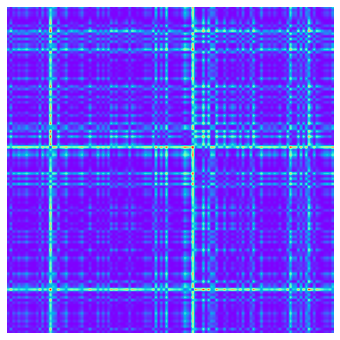

In [39]:
rand_observations = construct_many_rand_observations(30000)

In [ ]:
rand_observations